<a href="https://colab.research.google.com/github/ranjith13119/CNN/blob/main/fashion_mnist_with_hyper_paramter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
fashion_mnist=keras.datasets.fashion_mnist

In [ ]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

In [ ]:
len(train_images)

60000

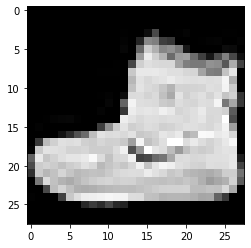

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0], cmap='gray')

In [ ]:
#train_images = np.expand_dims(train_images, axis=-1)

In [ ]:
train_images=train_images/255.0
test_images=test_images/255.0

In [ ]:
train_images[0].shape

(28, 28)

In [ ]:
train_images=train_images.reshape(len(train_images),28,28,1)
test_images=test_images.reshape(len(test_images),28,28,1)

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        kernel_initializer='he_uniform',
        input_shape=(28,28,1)
    ),
    keras.layers.MaxPool2D( pool_size=2, strides=2 ),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        kernel_initializer='he_uniform',
        activation='relu'
    ),
    keras.layers.MaxPool2D( pool_size=2, strides=2 ),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              #loss = 'categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output_23',project_name="Mnist Fashion_1")

INFO:tensorflow:Reloading Oracle from existing project output_23/Mnist Fashion_1/oracle.json


ReduceLROnPlateau callback that reduces the learning rate by some factor whenever the learning stagnates. It is believed that sometimes our model will benefit from lowering the learning rate when trapped in the plateau region.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.1,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [ ]:
 """ training_generator = train_datagen.flow(train_images, train_labels, batch_size=64,subset='training',seed=7)
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=64,subset='validation',seed=7)
from keras.preprocessing.image import ImageDataGenerator,load_img
train_datagen = ImageDataGenerator(
                                  rescale=1/255.,
                                  rotation_range=15,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1
                                ) """

" training_generator = train_datagen.flow(train_images, train_labels, batch_size=64,subset='training',seed=7)\nvalidation_generator = train_datagen.flow(train_images, train_labels, batch_size=64,subset='validation',seed=7)\nfrom keras.preprocessing.image import ImageDataGenerator,load_img\ntrain_datagen = ImageDataGenerator(\n                                 rescale=1/255.,\n                                 rotation_range=15,\n                                 shear_range=0.1,\n                                 zoom_range=0.2,\n                                 horizontal_flip=True,\n                                 width_shift_range=0.1,\n                                 height_shift_range=0.1\n                               ) "

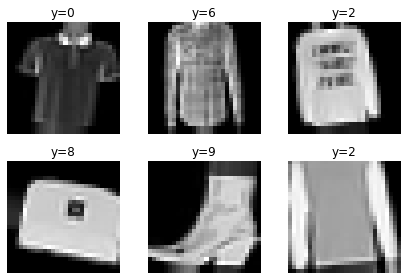

In [ ]:
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in training_generator:
        plt.imshow((x[0]/255).reshape(28,28),cmap='gray')
        plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner_search.search(train_images,train_labels,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 00m 30s]
val_accuracy: 0.8314999938011169

Best val_accuracy So Far: 0.8856666684150696
Total elapsed time: 00h 02m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = tuner_search.get_best_models(num_models = 1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 48)          38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 48)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0

In [ ]:
r = model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3,callbacks=callbacks)

Epoch 4/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3535 - accuracy: 0.8704 - val_loss: 0.2961 - val_accuracy: 0.8942
Epoch 5/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3435 - accuracy: 0.8729 - val_loss: 0.2812 - val_accuracy: 0.8922
Epoch 6/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3258 - accuracy: 0.8774 - val_loss: 0.2685 - val_accuracy: 0.9035
Epoch 7/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3125 - accuracy: 0.8830 - val_loss: 0.2606 - val_accuracy: 0.9043
Epoch 8/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3052 - accuracy: 0.8849 - val_loss: 0.2613 - val_accuracy: 0.9062
Epoch 9/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2953 - accuracy: 0.8909 - val_loss: 0.2506 - val_accuracy: 0.9078
Epoch 10/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2878 - accuracy: 0.8893 - val_loss: 0.2671 - val_accuracy